# Import library and read data file

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [49]:
# số timestep
n_timestep = 15
n_timepred = 1
# số thuộc tính mỗi timestep
n_feature = 9
# chia tập dữ liệu thành 75% để train, 12.5% để validation và 12.5% để test
train_val_test_rate = (0.75, 0.125, 0.125)

In [50]:
dataset = pd.read_csv('/content/drive/MyDrive/machine_learning/raw_data/dataset_new.csv', index_col='datetime', parse_dates=True)
unnoise_dataset = pd.read_csv('/content/drive/MyDrive/machine_learning/raw_data/unnoise_dataset.csv', index_col='datetime', parse_dates=True)

In [51]:
dataset.head()

,tempmax,tempmin,temp,dew,humidity,precip,windspeed,cloudcover,visibility
datetime,,,,,,,,,
2015-01-01,24.0,8.5,17.6,9.3,64.0,0.0,13.0,0.0,7.1
2015-01-02,22.0,11.0,16.3,9.4,65.5,0.0,13.9,0.0,7.7
2015-01-03,21.0,13.1,17.0,12.4,75.3,0.0,13.0,0.0,5.8
2015-01-04,22.3,16.9,19.3,16.1,81.9,0.0,16.8,1.0,6.2
2015-01-05,23.0,18.5,20.4,18.4,88.3,0.0,13.0,1.0,4.0


In [52]:
unnoise_dataset.head()

,tempmax,tempmin,temp,dew,humidity,precip,windspeed,cloudcover,visibility
datetime,,,,,,,,,
2015-01-01,22.0,8.5,16.3,9.3,64.0,0.0,13.0,0.0,7.1
2015-01-02,22.0,11.0,17.0,9.4,65.5,0.0,13.0,0.0,7.1
2015-01-03,22.0,13.1,17.0,12.4,75.3,0.0,13.9,0.0,6.2
2015-01-04,22.3,16.9,19.3,16.1,81.9,0.0,13.0,1.0,5.8
2015-01-05,23.0,18.5,20.4,16.1,88.0,0.0,13.0,1.0,4.2


# Generate Dataset

Scaling

In [53]:
from sklearn.preprocessing import MinMaxScaler

In [54]:
scaler = MinMaxScaler()
scaled_unnoise_dataset = scaler.fit_transform(unnoise_dataset)

In [55]:
scaled_unnoise_dataset[:5]

array([[0.41139241, 0.07172996, 0.32384342, 0.37800687, 0.42926829,
        0.        , 0.21774194, 0.        , 0.47191011],
       [0.41139241, 0.17721519, 0.34875445, 0.3814433 , 0.45365854,
        0.        , 0.21774194, 0.        , 0.47191011],
       [0.41139241, 0.26582278, 0.34875445, 0.48453608, 0.61300813,
        0.        , 0.25403226, 0.        , 0.37078652],
       [0.42088608, 0.42616034, 0.43060498, 0.61168385, 0.7203252 ,
        0.        , 0.21774194, 1.        , 0.3258427 ],
       [0.44303797, 0.49367089, 0.46975089, 0.61168385, 0.8195122 ,
        0.        , 0.21774194, 1.        , 0.14606742]])

Split data

In [56]:
idx_train = int(train_val_test_rate[0] * len(scaled_unnoise_dataset))
idx_val = int((train_val_test_rate[0] + train_val_test_rate[1]) * len(scaled_unnoise_dataset))
train_set = np.array(scaled_unnoise_dataset[:idx_train])
val_set = np.array(scaled_unnoise_dataset[idx_train:idx_val])
test_set = np.array(scaled_unnoise_dataset[idx_val:])

In [57]:
train_set.shape, val_set.shape, test_set.shape

((2191, 9), (365, 9), (366, 9))

Timestep split

In [58]:
def timestep_split(data, n_step):
  X, y = [], []

  for i in range(len(data) - n_step):
    end_idx = i + n_step
    seq_X = data[i:end_idx]
    seq_y = data[end_idx]
    X.append(seq_X)
    y.append(seq_y)

  return np.array(X), np.array(y)

In [59]:
X_train, y_train = timestep_split(data=train_set, n_step=n_timestep)
X_val, y_val = timestep_split(data=val_set, n_step=n_timestep)
X_test, y_test = timestep_split(data=test_set, n_step=n_timestep)

In [60]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2176, 15, 9), (2176, 9), (350, 15, 9), (350, 9), (351, 15, 9), (351, 9))

# Build model

In [61]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

In [62]:
model = Sequential()
model.add(Input(shape=(n_timestep, n_feature), name='Input'))
model.add(LSTM(units=64,
               activation='tanh',
               recurrent_activation='sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               dropout=0.0,
               recurrent_dropout=0.0,
               return_sequences=True,
               name='LSTM_many_to_many'))
model.add(LSTM(units=64,
               activation='tanh',
               recurrent_activation='sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               dropout=0.0,
               recurrent_dropout=0.0,
               name='LSTM_many_to_one'))
model.add(Dense(units=n_feature,
                activation='sigmoid',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                name='Output_layer'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                              beta_1=0.9,
                              beta_2=0.999,
                              epsilon=1e-08)
model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_many_to_many (LSTM)    (None, 15, 64)            18944     
                                                                 
 LSTM_many_to_one (LSTM)     (None, 64)                33024     
                                                                 
 Output_layer (Dense)        (None, 9)                 585       
                                                                 
Total params: 52,553
Trainable params: 52,553
Non-trainable params: 0
_________________________________________________________________


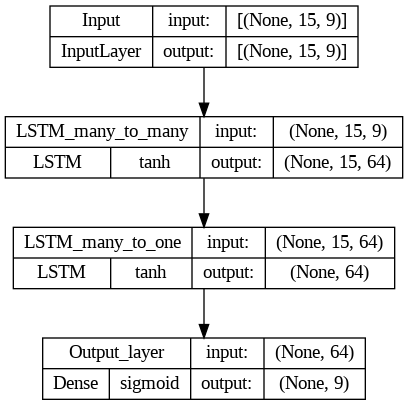

In [63]:
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, show_layer_names=True)

# Train

In [64]:
path = '/content/drive/MyDrive/machine_learning/model/LSTM_model.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True)

In [65]:
model.fit(X_train, y_train, epochs=50, verbose=0, callbacks=[checkpoint], batch_size=4,
          validation_data=(X_val, y_val), validation_batch_size=4)

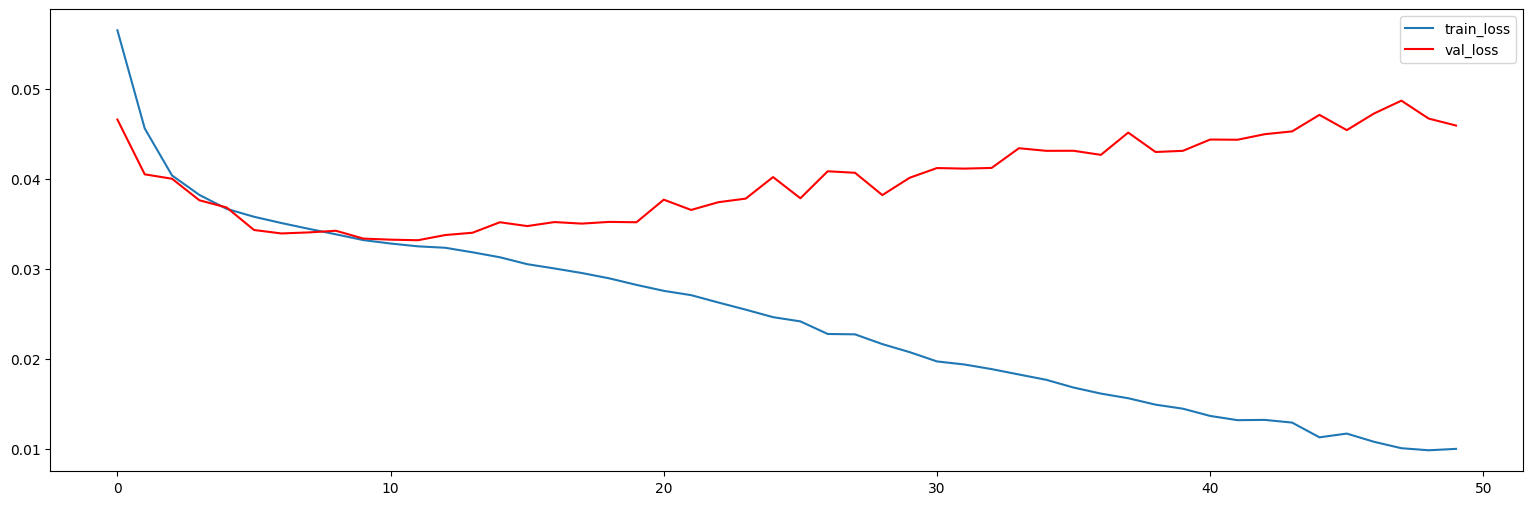

In [66]:
plt.figure(figsize=(19, 6))
plt.plot(model.history.history['loss'], label='train_loss')
plt.plot(model.history.history['val_loss'], c='red', label='val_loss')
plt.legend()

# Evaluate

In [67]:
model = keras.models.load_model('/content/drive/MyDrive/machine_learning/model/LSTM_model.h5')

In [68]:
def predict(model, X, n_pred=1):
  pred = []
  for idx in range(0, len(X) - n_pred):
    X_i = X[idx][None]
    y_i = model.predict(X_i, verbose=0)
    pred.append(y_i)
    if y_i[0][5] < 0.5:
        y_i[0][5] = 0
    else:
        y_i[0][5] = 1
    y_i[0][7] = round(y_i[0][7])

  if len(X) % n_pred == 0:
    n = len(X) - n_pred
  else:
    n = len(X) - len(X)%n_pred
  return np.array(pred).reshape(n, n_feature)

In [69]:
y_predict = predict(model, X_test, n_pred=n_timepred)
y_predict = scaler.inverse_transform(y_predict)
y_unnoise = scaler.inverse_transform(y_test)

In [70]:
tmax_pred, tmin_pred, t_pred, dew_pred, humidity_pred, precip_pred, windspeed_pred, cloudcover_pred, visibility_pred = y_predict[:,0], y_predict[:,1], y_predict[:,2], y_predict[:,3], y_predict[:,4], y_predict[:,5], y_predict[:,6], y_predict[:,7], y_predict[:,8]

start_idx = n_timestep
end_idx = (len(y_test) - len(y_test)%n_timepred) if len(y_test)%n_timepred != 0 else (len(y_test) - n_timepred)

y_unnoise = y_unnoise[:end_idx, :]
tmax_unnoise, tmin_unnoise, t_unnoise, dew_unnoise, humidity_unnoise, precip_unnoise, windspeed_unnoise, cloudcover_unnoise, visibility_unnoise = y_unnoise[:,0], y_unnoise[:,1], y_unnoise[:,2], y_unnoise[:,3], y_unnoise[:,4], y_unnoise[:,5], y_unnoise[:,6], y_unnoise[:,7], y_unnoise[:,8]

y_real_test = np.array(dataset[idx_val:])
y_real_test = y_real_test[start_idx : end_idx+start_idx, : ]
tmax_real, tmin_real, t_real, dew_real, humidity_real, precip_real, windspeed_real, cloudcover_real, visibility_real = y_real_test[:,0], y_real_test[:,1], y_real_test[:,2], y_real_test[:,3], y_real_test[:,4], y_real_test[:,5], y_real_test[:,6], y_real_test[:,7], y_real_test[:,8]

In [71]:
y_real_test[:5]

array([[21.5, 16. , 18.1, 16. , 87.7,  0. ,  9.4,  1. ,  4. ],
       [24.4, 16. , 19.5, 17.2, 87. ,  1. , 24.1,  1. ,  5.6],
       [16. , 13. , 14.7, 12.1, 84.9,  1. , 20.5,  1. ,  9.7],
       [21.7, 15. , 17.5, 11.1, 67.7,  1. , 14.8,  0. ,  9.4],
       [22. , 13. , 17.3, 11.9, 73. ,  0. , 13. ,  0. ,  8.4]])

In [72]:
from keras.metrics import mean_absolute_error

In [73]:
end_idx = len(dataset) - len(y_test)%n_timepred
start_idx = end_idx - len(y_predict)

In [74]:
# Nhiệt độ cao nhất
tmax_mae_1 = float(mean_absolute_error(tmax_unnoise, tmax_pred))
tmax_mae_2 = float(mean_absolute_error(tmax_real, tmax_pred))

# Nhiệt độ thấp nhất
tmin_mae_1 = float(mean_absolute_error(tmin_unnoise, tmin_pred))
tmin_mae_2 = float(mean_absolute_error(tmin_real, tmin_pred))

# Nhiệt độ trung bình
t_mae_1 = float(mean_absolute_error(t_unnoise, t_pred))
t_mae_2 = float(mean_absolute_error(t_real, t_pred))

# Điểm sương
dew_mae_1 = float(mean_absolute_error(dew_unnoise, dew_pred))
dew_mae_2 = float(mean_absolute_error(dew_real, dew_pred))

# Độ ẩm
humidity_mae_1 = float(mean_absolute_error(humidity_unnoise, humidity_pred))
humidity_mae_2 = float(mean_absolute_error(humidity_real, humidity_pred))

# Độ che phủ mây
m = tf.keras.metrics.AUC()
m.update_state(cloudcover_real, cloudcover_pred)
cloudcover_accuracy = m.result().numpy()

# Tốc độ gió
windspeed_mae_1 = float(mean_absolute_error(windspeed_unnoise, windspeed_pred))
windspeed_mae_2 = float(mean_absolute_error(windspeed_real, windspeed_pred))

# Tầm nhìn
visibility_mae_1 = float(mean_absolute_error(visibility_unnoise, visibility_pred))
visibility_mae_2 = float(mean_absolute_error(visibility_real, visibility_pred))

# Mưa
BA_precip = keras.metrics.BinaryAccuracy(threshold=0.5)
BA_precip.update_state(precip_real, precip_pred)
R_Accuracy_precip = float(BA_precip.result())

In [75]:
conclusion = pd.DataFrame({
    'Predict' : ['t_max', 't_min', 't_tb', 'dew', 'humidity', 'cloud cover', 'wind speed', 'visibility', 'precip'],
    'Vs_unnoise_data' : [tmax_mae_1, tmin_mae_1, t_mae_1, dew_mae_1, humidity_mae_1, cloudcover_accuracy, windspeed_mae_1, visibility_mae_1, R_Accuracy_precip],
    'Vs_real_data' : [tmax_mae_2, tmin_mae_2, t_mae_2, dew_mae_2, humidity_mae_2, cloudcover_accuracy, windspeed_mae_2, visibility_mae_2, R_Accuracy_precip]
})

In [76]:
conclusion

,Predict,Vs_unnoise_data,Vs_real_data
0,t_max,1.278364,1.533586
1,t_min,0.932074,1.083774
2,t_tb,0.886488,0.998452
3,dew,1.086893,1.169369
4,humidity,3.779166,4.180093
5,cloud cover,0.733168,0.733168
6,wind speed,1.780439,2.751215
7,visibility,0.750590,0.858713
8,precip,0.820000,0.820000
